In [1]:
import networkx as nx
import csv
import math
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
G_all_roads = nx.MultiDiGraph()
both_false=[]
with open('Straßengraph/edges_th_with_frc.csv', newline='') as csvfile:
    with open('Straßengraph/coordinates_th.csv', newline='') as coordinates:    
        spamreader = csv.reader(csvfile, delimiter=';')
        cooreader = csv.reader(coordinates, delimiter=';')
        count=0
        coorrows = list(cooreader)
        for row in spamreader:        
            Id,u,v,length,maxspeed, maxspeedtrucks, IsF, IsB, Frc=row
            #print(type(Id))
            #print(Id)
            #interestingrows=[row for idx, row in enumerate(cooreader) if idx ==int(Id)]
            #interestingrows=[row2 for idx, row2 in enumerate(cooreader) if idx ==2]
            #print(coorrow[int(Id)])
            coorrow=coorrows[int(Id)]
            #length_of_coorrow=len(coorrow[int(Id)])
            #print(interestingrows)
            if(IsF=='True'):#forward=True
            #print(length1)
                G_all_roads.add_node(u,y=coorrow[1],x=coorrow[2])
                G_all_roads.add_node(v,y=coorrow[-2],x=coorrow[-1])
                G_all_roads.add_edge(u,v,Id=Id,length=int(length),maxspeed=float(maxspeed),maxspeedtrucks=float(maxspeedtrucks),
                            y1=coorrow[1],x1=coorrow[2],y2=coorrow[-2],x2=coorrow[-1],frc=int(Frc),time=int(length)/float(maxspeedtrucks))
            #WEprint(int(list(row)[1]), int(list(row)[2]))
            if(IsB=='True'):#forward=True
                G_all_roads.add_node(u,y=coorrow[1],x=coorrow[2])
                G_all_roads.add_node(v,y=coorrow[-2],x=coorrow[-1])
                G_all_roads.add_edge(v,u,Id=Id,length=int(length),maxspeed=float(maxspeed),maxspeedtrucks=float(maxspeedtrucks),
                           y1=coorrow[1],x1=coorrow[2],y2=coorrow[-2],x2=coorrow[-1],frc=int(Frc),time=int(length)/float(maxspeedtrucks))
            #if(IsF!='True' and IsB !="True"):
            #   both_false.append(Id)
            #count+=1
            #if count>3:
            #    break

In [3]:
coory=nx.get_node_attributes(G_all_roads,"y")
coorx=nx.get_node_attributes(G_all_roads,"x")
def dist(a, b):
    x1=float(coorx[a])
    x2=float(coorx[b])
    y1=float(coory[a])
    y2=float(coory[b])
    return(math.sqrt(((x1-x2)*71)**2+((y1-y2)*111)**2)*1000*100)

## Heuristic search

first check for some nodes the difference bettween the euclidean distance and the distance from the edge attributes

In [5]:
nodelist=list(G_all_roads.nodes())

In [6]:
random.seed(42)
sample_nodes=random.sample(nodelist,20)

In [4]:
lin=[]
with open('linear_reg.csv', newline= '') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        lin.append(list(row))
print(lin)


reg_coef=float(lin[0][0])
reg_inter=float(lin[0][1])
print(reg_coef,reg_inter)

[['-6.217415638559294e-09', '1.2599349825129136']]
-6.217415638559294e-09 1.2599349825129136


numpy.float64

## Use that heuristic for creating a distance Matrix of size 500*500

In [5]:
distanc_matrix_13=np.zeros((501,501))
#distanc_matrix_40=np.zeros((20,20))

In [6]:
midpoint_2=11280000+(16000000-11280000)/2
def give_fact_of_length_13(euc_dist):
    if(euc_dist<1300000):
        return 1.37
    elif(euc_dist<midpoint_2):
        #return model_13.intercept_+ euc_dist*model_13.coef_
        return (reg_inter+euc_dist*reg_coef)
    else:
        return 1.177

In [10]:
give_fact_of_length_13(100*100000)

1.1977608261273207

## Import points from VRP Edges File and generate distance Matrix

In [7]:
X=[]
with open('VRP-Instanz/Vrp_500_Jena_Edge_Ids.csv', newline= '') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ')
    for row in spamreader:
        X.append(list(row))
#print(X)
print(X[0][0])

693943


In [8]:
def get_key(val,my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key
 
    return "key doesn't exist"

In [9]:
ID_dict=nx.get_edge_attributes(G_all_roads,"Id")

In [10]:
importet_edges=[]
for i in range(len(X)):
    importet_edges.append(get_key(X[i][0],ID_dict))
importet_edges

depot=get_key("2231801",ID_dict)
depot

final_edges=[depot]
for i in range(500):
    final_edges.append(importet_edges[i])
final_edges[3]=get_key("814372",ID_dict)#Berichtigungen von Tobi
final_edges[28]=get_key("1005312",ID_dict)#Berichtigungen von Tobi
final_edges[187]=get_key("794153",ID_dict)#Berichtigungen von Tobi
final_edges[350]=get_key("950070",ID_dict)#Berichtigungen von Tobi


In [11]:
## With Heuristic long way from 13km:
distanc_matrix_13=np.zeros((501,501))
midpoint_2=11280000+(16000000-11280000)/2
start=time.time()
for i in range(501):#500 Customer plus depot
    #if(i%10==0):
            #print("Zehnte Iteration")
    for j in range(501):        
        euc_dist=dist(final_edges[i][0],final_edges[j][0])
        if(euc_dist<1300000):
            try:
                distanc_matrix_13[i][j]=nx.astar_path_length(G_all_roads,final_edges[i][0],final_edges[j][0],heuristic=dist,weight='length')
            except:
                distanc_matrix_13[i][j]=euc_dist*give_fact_of_length_13(euc_dist)
                print(i,j)
                print("node i,j,:",final_edges[i][0],final_edges[j][0])
            
        else:
            distanc_matrix_13[i][j]=euc_dist*give_fact_of_length_13(euc_dist)
end=time.time()
time_13=end-start
print(end-start)

349.3113498687744


for a 500 time 500 Matrix instead of a 20 times time Matrix, we need approx the (500/20)*(500/20)=25*25=625 amount of calculation time then in the current situation

that would lead, that we would need with the 13 heuristic 0.065*625 approx 40s of computation time

with the 40 heuristic, we would need 2.2*625 approx 1375s,=22min+55s

with the classic way, we would ne 295*625 approx 107675s=29,9h =29h+54min

## Import Time Matrix from former computation

In [12]:
time_list=[]
with open('time_matrix_after_opt.csv', newline= '') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        time_list.append(list(row))
time_matrix=np.zeros((501,501))
for i in range(501):
    for j in range(501):
        time_matrix[i][j]=float(time_list[i][j])

## Arbeiten mit den Längen

In [ ]:
(nx.astar_path_length(G_all_roads, sample_edges[0][0], sample_edges[1][0], heuristic=dist, weight='time'))

In [101]:
def tdist_60(a,b):##Heuristic für Durschnittsgeschwindigkeit von 60km/h
    return dist(a,b)/(60/36)








## Erstellen von Touren mit Neighrest Neighbors Approach

Idea, always choose the nearest neighbor of the current point to achieve the next point on the subtour,
if the subtour is longer then a specific length (or time), abort the subtour and go back to the depot

In [13]:
##Try the tour first with a 20*20 Distance Matrix

##Station left:
def search_tour_with_km_limt(distance_matrix,km_limit=500,size=501,sample_edges=importet_edges):
    #print("sra")
    stations_left=list(range(1,size))
    #print(stations_left)
## Abruchkriterium mit maximal 500km per Tour
    tourlist=[] #Listen von allen Subtouren, welche derzeitig bestehen
    last_station=0#letzte Station, wird in der Iteration häufig benutzt werden
    curr_tour=[]
    while(len(stations_left)>0):#
        #print("in while")
        if(curr_tour==[]):#Beginn beim Depot
            min_Distanz=1000000000000#some big Number
            next_station=533 ##Out auf Bound, falls es nicht funktion
            for station in stations_left:##Kleinste Station herausgefunden, add it to function
                if(distance_matrix[last_station][station]<min_Distanz):
                    next_station=station
                    min_Distanz=distance_matrix[last_station][station]
            curr_tour.append([next_station])
            curr_tour.append(min_Distanz)
            last_station=next_station
            stations_left.remove(next_station)
            #print(curr_tour)
        else:
            min_Distanz=1000000000000#some big Number
            next_station=32 ##Out auf Bound, falls es nicht funktion
            no_valid_Station=True#Check später in der Iteration, ob man Überhaupt noch eine Tour hinzufügen kann
            for station in stations_left:##Kleinste Station herausgefunden, add it to function
                this_station_is_valid=False#Check ob aktuell zu überprüfende Station gemäß des Abbruchkriterium valide ist
            #print(curr_tour)
                if(curr_tour[1]+distance_matrix[last_station][station]+distance_matrix[station][0]<km_limit*100000):
                    this_station_is_valid=True
                    no_valid_Station=False
                if(distance_matrix[last_station][station]<min_Distanz and this_station_is_valid):
                    next_station=station
                    min_Distanz=distance_matrix[last_station][station]
            if(no_valid_Station):##Es gibt keine Station mehr, die wir der Tour hinzufügen können
                #print("invalide, back to depot", curr_tour)
                curr_tour[1]+=distance_matrix[last_station][0]#Distanz von Endstation zu Depot muss noch hinzugefügt werden
                tourlist.append(curr_tour)
                last_station=0
                curr_tour=[]
            
            else:#Es wird eine Station hinzugefügt
                #print("Weiter suchen", curr_tour)
                curr_tour[0].append(next_station)
                curr_tour[1]+=min_Distanz
                last_station=next_station
            #print(next_station)
                stations_left.remove(next_station)
    return tourlist

In [14]:
begin=time.time()
tours=search_tour_with_km_limt(distanc_matrix_13,size=501)
end=time.time()
print(end-begin)
for tour in tours:
    print(tour[0])
    print(tour[1]/100000)

0.180755615234375
[172, 293, 156, 73, 220, 193, 94, 101, 283, 423, 410, 291, 292, 402, 364, 399, 195, 19, 446, 78, 397, 266, 263, 138, 8, 34, 167, 205, 56, 264, 314, 379, 451, 385, 11, 366, 422, 353, 23, 435, 478, 440, 96, 262, 39, 28, 87, 279, 13, 265, 377, 194, 313, 318, 182, 55, 309, 326, 204, 118, 125, 229, 315, 149, 289, 252, 462, 480, 103, 413, 257, 486, 280, 124, 238, 181, 255, 224, 296, 113, 297, 454, 177, 330, 243, 258, 328, 335, 316, 420, 43, 9, 90, 115, 393, 311, 64, 65, 439, 317, 332, 281, 312, 260, 130, 387, 214, 348, 247, 414, 150, 59, 323, 359, 373, 401, 27, 288, 54, 350, 299, 489, 424, 245, 22, 51, 139, 487, 60, 409, 100, 70, 201, 468, 300, 192, 169, 83, 232, 189, 233, 490, 476, 162, 81, 126, 438, 383, 128, 352, 2, 282, 448, 146, 226, 200, 24, 18, 41, 48, 384, 428, 190, 58, 199, 368, 134]
498.64496136583006
[273, 228, 390, 400, 339, 7, 407, 472, 360, 1, 186, 433, 488, 52, 148, 437, 306, 371, 208, 396, 183, 187, 349, 492, 140, 417, 236, 367, 322, 82, 416, 129, 464, 127, 

## Touren mit Nearest Neighbor mit Zeitlimit

In [23]:
time_matrix=np.zeros((20,20))

In [13]:
def search_tour_with_time_limt(distance_matrix,timelimit=9,size=20,time_matrix=np.zeros((20,20)),sample_edges=final_edges):
#def search_tour_with_time_limt(distance_matrix,timelimit=9,size=20,time_matrix,sample_edges):
    stations_left=list(range(1,size))
## Abruchkriterium mit maximal timelimit per Tour
    tourlist=[] #Listen von allen Subtouren, welche derzeitig bestehen
    last_station=0#letzte Station, wird in der Iteration häufig benutzt werden
    curr_tour=[]
    while(len(stations_left)>0):#
    #print("in while")
        if(curr_tour==[]):#Beginn beim Depot
            #print("wieder hier")
            min_Distanz=1000000000000#some big Number
            next_station=3200 ##Out auf Bound, falls es nicht funktion
            for station in stations_left:##Kleinste Station herausgefunden, add it to function
                if(distance_matrix[last_station][station]<min_Distanz):
                    next_station=station
                    min_Distanz=distance_matrix[last_station][station]
            #print(next_station)
            ##Station ist klar, jetzt kann die Zeit zur nächsten Station berechnet werden
            add_time=0
            if(time_matrix[last_station][next_station]>0):
                add_time=time_matrix[last_station][next_station]
            else:
                try:
                    time_matrix[last_station][next_station]=nx.astar_path_length(G_all_roads,sample_edges[last_station][0],sample_edges[next_station][0],heuristic=tdist_60,weight='time')/(3600*1000)
                    add_time=time_matrix[last_station][next_station]
                except:
                    time_matrix[last_station][next_station]=distance_matrix[last_station][next_station]/((60/36)*(3600*1000))#Schätze benötigt Zeit anhand euclid distanz plus Durchschnittsgeschwindigkeit von 60km/h
                    add_time=time_matrix[last_station][next_station]
                    print("Error: ",last_station,next_station)
            add_time+=(2/60)#Servicezeit von 2 min hinzufügen
            curr_tour.append([next_station])
            curr_tour.append(min_Distanz)
            curr_tour.append(add_time)
            last_station=next_station
            stations_left.remove(next_station)
            #print(curr_tour,stations_left)
        else:
            min_Distanz=1000000000000#some big Number
            next_station=3200 ##Out auf Bound, falls es nicht funktioniert
            no_valid_Station=True#Check später in der Iteration, ob man Überhaupt noch eine Tour hinzufügen kann
            stations_for_this_station=stations_left.copy()
            
            counter=0
            no_more_valid_points=True
            #while((counter<5 or counter<len(stations_for_this_station)) and len(stations_for_this_station)>0):#Es reicht die ersten fünf zu überprüfen, sehr unwahrscheinlich, dass eine Strecke, mit längerer Entfernung eine kürzere Zeit in Anspruch nimmt
            while(counter<5 and len(stations_for_this_station)>counter):
            #while(counter==0):
                min_Distanz=1000000000000
                for station in stations_for_this_station:##Kleinste Station herausgefunden, add it to function
                    #this_station_is_valid=False#Check ob aktuell zu überprüfende Station gemäß des Abbruchkriterium valide ist
            #print(curr_tour)
                    if(distance_matrix[last_station][station]<min_Distanz):
                        next_station=station
                        min_Distanz=distance_matrix[last_station][station]
                add_time=0
                if(time_matrix[last_station][next_station]>0):
                    add_time=time_matrix[last_station][next_station]
                else:
                    try:
                        time_matrix[last_station][next_station]=nx.astar_path_length(G_all_roads,sample_edges[last_station][0],sample_edges[next_station][0],heuristic=tdist_60,weight='time')/(3600*1000)
                        add_time=time_matrix[last_station][next_station]
                    except:
                        time_matrix[last_station][next_station]=distance_matrix[last_station][next_station]/((60/36)*(3600*1000))#Schätze benötigt Zeit anhand euclid distanz plus Durchschnittsgeschwindigkeit von 60km/h
                        add_time=time_matrix[last_station][next_station]
                        print("Error: ",last_station,next_station)
                back_to_depot_time=0
                if(time_matrix[next_station][0]>0):
                    back_to_depot_time=time_matrix[next_station][0]
                else:
                    try:
                        time_matrix[next_station][0]=nx.astar_path_length(G_all_roads,sample_edges[next_station][0],sample_edges[0][0],heuristic=tdist_60,weight='time')/(3600*1000)
                        back_to_depot_time=time_matrix[next_station][0]
                    except:
                        time_matrix[next_station][0]=distance_matrix[next_station][0]/((60/36)*(3600*1000))#Schätze benötigt Zeit anhand euclid distanz plus Durchschnittsgeschwindigkeit von 60km/h
                        back_to_depot_time=time_matrix[next_station][0]
                        print("Error: ",next_station,0)
                if(curr_tour[2]+add_time+(2/60)+back_to_depot_time<timelimit):#Ausgewählte station is valide
                    ##Hinzufügen der Station zur Tour
                    add_time+=(2/60)#Servicezeit von 2 min hinzufügen
                    curr_tour[0].append(next_station)
                    curr_tour[1]+=min_Distanz
                    curr_tour[2]+=add_time
                    #print(curr_tour)
                    stations_left.remove(next_station)
                    last_station=next_station
                    no_more_valid_points=False
                    if(len(stations_left)==0):##Tour muss hinzugefügt werden, Programm geht in oberste while Schleife, weil len==0 Bedingung nicht erfüllt-> Tour würde nicht hinzugefügt werden
                        curr_tour[1]+=distance_matrix[next_station][0]
                        curr_tour[2]+=back_to_depot_time
                        tourlist.append(curr_tour)
                    break
                else:
                    counter+=1
                    #print(next_station,stations_for_this_station,counter)
                    stations_for_this_station.remove(next_station)#im Nächsten Versuch der While Schleife soll natürlich diese Station nicht mehr abgefragt werden
            if(no_more_valid_points):#->Es wurde keine weitere Station gefunden, welche das Kriterium erfüllt, zurück zum Depot
                back_to_depot_time
                if(time_matrix[last_station][0]>0):
                    back_to_depot_time=time_matrix[last_station][0]
                else:
                    try:
                        time_matrix[last_station][0]=nx.astar_path_length(G_all_roads,sample_edges[last_station][0],sample_edges[0][0],heuristic=tdist_60,weight='time')/(3600*1000)
                        back_to_depot_time=time_matrix[last_station][0]
                    except:
                        time_matrix[last_station][0]=distance_matrix[last_station][0]/((60/36)*(3600*1000))#Schätze benötigt Zeit anhand euclid distanz plus Durchschnittsgeschwindigkeit von 60km/h
                        back_to_depot_time=time_matrix[last_station][0]
                        print("Error: ",last_station,0)
                curr_tour[1]+=distance_matrix[last_station][0]
                curr_tour[2]+=back_to_depot_time
                tourlist.append(curr_tour)
                curr_tour=[]
                last_station=0
    return tourlist

In [17]:
#time_matrix=np.zeros((501,501))

In [14]:
begin=time.time()
tours_with_times=search_tour_with_time_limt(distanc_matrix_13,timelimit=9,size=501,time_matrix=time_matrix)
end=time.time()
print(end-begin)

Error:  25 26
Error:  108 109
0.05043339729309082


In [15]:
for tour in tours_with_times:
    print(tour[0])
    print(tour[1]/100000,tour[2])

[172, 293, 156, 73, 220, 193, 94, 101, 283, 423, 410, 291, 292, 402, 364, 399, 195, 19, 446, 78, 397, 266, 263, 138, 8, 34, 167, 205, 56, 264, 314, 379, 451, 385, 11, 366, 422, 353, 23, 435, 478, 440, 96, 262, 39, 28, 87, 279, 13, 265, 377, 194, 313, 318, 182, 55, 309, 326, 204, 118, 125, 229, 315, 149, 289, 252, 462, 480, 103, 413, 257, 486, 280, 124, 238, 181, 255, 224, 296, 113, 297, 454, 177, 330, 243, 258, 328, 335, 316, 420, 76]
234.85102722385835 8.977783740090695
[273, 228, 390, 400, 339, 134, 368, 407, 7, 305, 86, 107, 381, 5, 447, 404, 212, 259, 388, 375, 474, 38, 174, 384, 48, 41, 18, 24, 200, 191, 396, 208, 183, 187, 349, 492, 140, 417, 236, 367, 322, 82, 416, 129, 464, 127, 196, 445, 178, 117, 17, 256, 254, 246, 62, 216, 395, 418, 44, 133, 358, 370, 3, 419]
300.5883880728971 8.955272234101018
[360, 472, 1, 186, 433, 199, 488, 52, 148, 437, 306, 371, 336, 165, 102, 483, 111, 45, 457, 482, 66, 484, 240, 2, 126, 81, 162, 448, 282, 146, 226, 476, 438, 383, 128, 352, 169, 192, 

In [16]:
len(tours_with_times)

9

In [21]:
##Berichtigen im entsprechenden file
tourlist=[]
with open('begin_of_tour_real_data.csv') as csv_file:
    csv_read=csv.reader(csv_file, delimiter=',')
    for row in csv_read:
        tourlist.append(row)

In [17]:
##Nicht beim Einlesen
tourlist=[]
for tour in tours_with_times:
    stations=[]
    for i in range(len(tour[0])):
        stations.append(tour[0][i])
    #curr_tour=[stations,tour[-2],tour[-1]]
    stations.append(tour[-2])
    stations.append(tour[-1])
    tourlist.append(stations)


In [18]:
tourlist[0][1]

293

In [19]:
for i in range(len(tourlist)):
    for j in range(len(tourlist[i])-2):
        tourlist[i][j]=int(tourlist[i][j])
    tourlist[i][-1]=float(tourlist[i][-1])
    tourlist[i][-2]=float(tourlist[i][-2])

In [98]:
tourlist

[[172,
  293,
  156,
  73,
  220,
  193,
  94,
  101,
  283,
  423,
  410,
  291,
  292,
  402,
  364,
  399,
  195,
  19,
  446,
  78,
  397,
  266,
  263,
  138,
  8,
  34,
  167,
  205,
  56,
  264,
  314,
  379,
  451,
  385,
  11,
  366,
  422,
  353,
  23,
  435,
  478,
  440,
  96,
  262,
  39,
  28,
  87,
  279,
  13,
  265,
  377,
  194,
  313,
  318,
  182,
  55,
  309,
  326,
  204,
  118,
  125,
  229,
  315,
  149,
  289,
  252,
  462,
  480,
  103,
  413,
  257,
  486,
  280,
  124,
  238,
  181,
  255,
  224,
  296,
  113,
  297,
  454,
  177,
  330,
  243,
  258,
  328,
  335,
  316,
  420,
  76,
  23485102.722385835,
  8.977783740090695],
 [273,
  228,
  390,
  400,
  339,
  134,
  368,
  407,
  7,
  305,
  86,
  107,
  381,
  5,
  447,
  404,
  212,
  259,
  388,
  375,
  474,
  38,
  174,
  384,
  48,
  41,
  18,
  24,
  200,
  191,
  396,
  208,
  183,
  187,
  349,
  492,
  140,
  417,
  236,
  367,
  322,
  82,
  416,
  129,
  464,
  127,
  196,
  445,
  178,
  11

In [25]:
sample_edges[397]

('9895952', '6827752')

In [99]:
print(coorx[sample_edges[397][0]],coory[sample_edges[397][0]])

NameError: name 'sample_edges' is not defined

In [20]:
print(depot)

('11679160', '8827990', 0)


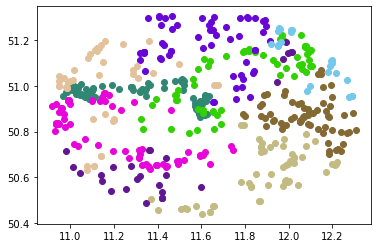

In [21]:
plt.scatter(float(coorx[depot[0]]),float(coory[depot[0]]),color="green")
random.seed(42)
#for tour in tourlist:
for j in range(len(tourlist)):
    tour=tourlist[j]
    rand_col=("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    for i in range(len(tour)-2):
        try:
            plt.scatter(float(coorx[final_edges[tour[i]][0]]),float(coory[final_edges[tour[i]][0]]),color=rand_col)
        except:
            print(i,j)
        
plt.show()

In [34]:
tourlist[13][7]

500

In [87]:
len(tourlist)

61

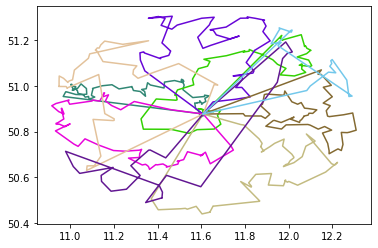

In [22]:

random.seed(42)
for i in range(len(tourlist)):
    xvalues=[float(coorx[final_edges[0][0]])]
    yvalues=[float(coory[final_edges[0][0]])]
    rand_col=("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    for j in range(len(tourlist[i])-2):
        xvalues.append(float(coorx[final_edges[tourlist[i][j]][0]]))
        yvalues.append(float(coory[final_edges[tourlist[i][j]][0]]))
    xvalues.append(float(coorx[final_edges[0][0]]))
    yvalues.append(float(coory[final_edges[0][0]]))
    plt.plot(xvalues,yvalues,color=rand_col)
plt.show()
    

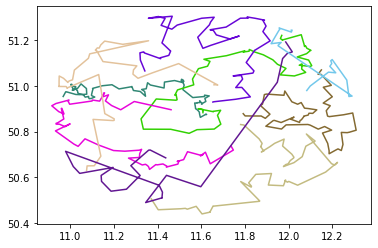

In [23]:
random.seed(42)
for i in range(len(tourlist)):
    #xvalues=[float(coorx[sample_edges[0][0]])]
    #yvalues=[float(coory[sample_edges[0][0]])]
    xvalues=[]
    yvalues=[]
    rand_col=("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    for j in range(len(tourlist[i])-2):
        xvalues.append(float(coorx[final_edges[tourlist[i][j]][0]]))
        yvalues.append(float(coory[final_edges[tourlist[i][j]][0]]))
    #xvalues.append(float(coorx[sample_edges[0][0]]))
    #yvalues.append(float(coory[sample_edges[0][0]]))
    plt.plot(xvalues,yvalues,color=rand_col)
plt.show()


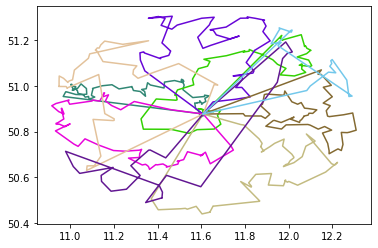

In [24]:
random.seed(42)
for i in range(len(tourlist)):
    xvalues=[float(coorx[final_edges[0][0]])]
    yvalues=[float(coory[final_edges[0][0]])]
    rand_col=("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    for j in range(len(tourlist[i])-2):
        j=len(tourlist[i])-2-j-1
        xvalues.append(float(coorx[final_edges[tourlist[i][j]][0]]))
        yvalues.append(float(coory[final_edges[tourlist[i][j]][0]]))
    xvalues.append(float(coorx[final_edges[0][0]]))
    yvalues.append(float(coory[final_edges[0][0]]))
    plt.plot(xvalues,yvalues,color=rand_col)
plt.show()
    

In [25]:
time_of_all_tours=0
length_of_all_tours=0
for tour in tourlist:
    time_of_all_tours+=tour[-1]
    length_of_all_tours+=tour[-2]
print(time_of_all_tours,length_of_all_tours/100000)

76.65225971309965 2702.255857934249


In [28]:
for tour in tourlist:
    print(time_of_tour(tour[0:(len(tour)-2)]))

NameError: name 'time_of_tour' is not defined

In [32]:
def length_of_tour(tour):
    length=0
    length+=distanc_matrix_13[0][int(tour[0])]
    for i in range(len(tour)-1):
        length+=distanc_matrix_13[int(tour[i])][int(tour[i+1])]
    length+=distanc_matrix_13[int(tour[-1])][0]
    return length


In [33]:
length_of_tour(random_tour)/100000

NameError: name 'random_tour' is not defined

In [34]:
tourlist[2][-2]/100000

311.73726147036575

In [38]:
length_of_tour(tourlist[2][0:len(tourlist[2])-2])/100000

311.73726147036575

In [39]:
def time_of_tour(tour):
    time=0
    if(time_matrix[0][int(tour[0])]>0):
        time+=time_matrix[0][int(tour[0])]
    else:
        try:
            time_matrix[0][int(tour[0])]=nx.astar_path_length(G_all_roads,final_edges[0][0],final_edges[int(tour[0])][0],heuristic=tdist_60,weight='time')/(3600*1000)
            time+=time_matrix[0][int(tour[0])]
        except:
            print("error",0,tour[0])
            time_matrix[int(0)][int(tour[0])]=distanc_matrix_13[0][int(tour[0])]/(60/36)
            time+=time_matrix[int(0)][int(tour[0])]
            time+=(2/60)#add service tine
    for i in range(len(tour)-1):
        if(time_matrix[int(tour[i])][int(tour[i+1])]>0):
            time+=time_matrix[int(tour[i])][int(tour[i+1])]
            time+=(2/60)#add service tine
        else:
            try:
                time_matrix[int(tour[i])][int(tour[i+1])]=nx.astar_path_length(G_all_roads,final_edges[int(tour[i])][0],final_edges[int(tour[i+1])][0],heuristic=tdist_60,weight='time')/(3600*1000)
                time+=time_matrix[int(tour[i])][int(tour[i+1])]
                time+=(2/60)#add service tine
            except:
                print("error",tour[i],tour[i+1])
                time_matrix[int(tour[i])][int(tour[i+1])]=distanc_matrix_13[int(tour[i])][int(tour[i+1])]/(60/36)
                time+=time_matrix[int(tour[i])][int(tour[i+1])]
                time+=(2/60)#add service tine
    if(time_matrix[int(tour[-1])][0]>0):
        time+=time_matrix[int(tour[-1])][0]
    else:
        try:
            time_matrix[int(tour[-1])][0]=nx.astar_path_length(G_all_roads,final_edges[int(tour[-1])][0],final_edges[0][0],heuristic=tdist_60,weight='time')/(3600*1000)
            time+=time_matrix[int(tour[-1])][0]
        except:
            print("error",0,tour[0])
            time_matrix[int(tour[-1])][0]=distanc_matrix_13[int(tour[-1])][0]/(60/36)
            time+=time_matrix[int(tour[-1])][0]
    
    return time


In [41]:
#2-opt with first improvement strategy: remove two edges and put two other edges in -> inverse a segment of costumer ordering

#n=len(random_tour)
#a 2-opt step:

#new_tour=np.zeros(n)
#for m in range(0,n):
#    new_tour[m]=int(random_tour[m])

def first_improvement(new_tour,distance_matrix,tour_length):
    n=len(new_tour)
    for i in range(2,n): #size of segment; 1 and n don't change the tour
        for j in range(0,n-i+1): #start of segment j end of segment i+j-1
            
            loop_tour=np.zeros(n)
            for m in range(0,n):
                loop_tour[m]=int(new_tour[m])
            
            inverse_segment=np.zeros(i)
            
            for m in range(0,i):
                inverse_segment[m]=loop_tour[j:i+j][::-1][m]
                
            s=0
            
            for k in range(j,i+j): #create the new tour
                while s<i:
                    loop_tour[j+s]=inverse_segment[s]
                    #print(inverse_segment[s])
                    s=s+1
                
            current_l=length_of_tour(loop_tour)
            #print(l)
        
            if current_l<tour_length: #do change the tour if an improvement is found
                #new_tour_length=current_l
                new_tour=loop_tour
                #print(loop_tour)
                break
            
            #else:
                #new_tour=np.zeros(n)
                #for m in range(0,n):
                    #new_tour[m]=int(random_tour[m])
                    
        if current_l<tour_length: #do change the tour if an improvement is found
            break
                    
    return new_tour,current_l
      

In [42]:
#multiple 2-opt steps:

def twoopt(random_tour,distance_matrix):
    
    #initialize tour_length and new_tour
    
    tour_length=length_of_tour(random_tour)
    n=len(random_tour)
    new_tour=np.zeros(n)
    for m in range(0,n):
        new_tour[m]=int(random_tour[m])
        
    #do multiple 2-opt steps
        
    new_length=tour_length
    
    while new_length<=tour_length:
        
        FI2OPT=first_improvement(new_tour,distance_matrix,tour_length)
    
        new_length=FI2OPT[1]
    
        if new_length<tour_length:
            new_tour=FI2OPT[0]
            tour_length=FI2OPT[1]
            #print(tour_length)
        
        else:
            break
        
    return new_tour,tour_length

In [43]:
#tourlist[2][0:(len(tourlist[2])-2)]
twoopt(tourlist[2][0:(len(tourlist[2])-2)],distanc_matrix_13)

(array([360., 472.,   1., 186., 433., 199., 148.,  52., 488., 437., 306.,
        371., 336., 165., 102., 483., 111., 457.,  45., 482.,  66., 484.,
        240.,   2., 126.,  81., 162., 282., 448., 146., 226., 476., 438.,
        383., 128., 352., 169., 490.,  83., 232., 189., 233., 300., 192.,
        201.,  70., 100., 409.,  60., 487., 139.,  54., 288.,  27., 401.,
        373., 359., 350.,  22.]),
 30296649.239821445)

In [44]:
#fist improvement strategy

def tour_replace(random_tour,tour_length):
    n=len(random_tour)
    new_tour=np.zeros(n)
    for m in range(0,n):
        new_tour[m]=int(random_tour[m])
        
    current_length=0
    l=tour_length
    a=0
    
    for i in range(0,n): #pick the position of the costumer to replace #PROBLEM: doesn't increase i!!!
        
        #print('i:',i)
        
        replace=int(new_tour[i]) #costumer-1
        #print(replace)
        
        for j in range(0,n): #pick new spot for the costumer
            
            #print('j:',j)
            
            if i==j:
                #print("gleich")
                continue #no change would happen
               
            
            new_tour=np.zeros(n)
            for m in range(0,n):
                new_tour[m]=int(random_tour[m])
               
            
            loop_tour=np.zeros(n)
            for m in range(0,n): #create the new tour
                loop_tour[m]=int(new_tour[m])
                
            #print(loop_tour)
            
            loop_tour[j]=replace
                
            for m in range(0,n):
                                 
                if j>i:
                        
                    if m>=i and m<j:
                        
                        loop_tour[m]=new_tour[m+1]
                        #print(new_tour[m+1])
                                        
                if j<i:
                        
                    if m>j and m<=i:
                        
                        loop_tour[m]=new_tour[m-1]
                        #print(new_tour[m-1])
                        
            #print(loop_tour)                
                        
            current_length=length_of_tour(loop_tour) #length of the created tour
            #print(current_length)
                
            if current_length<l and current_length>0:
                new_tour=loop_tour
                l=current_length
                #print(l)
                #print(loop_tour)
                a=1
                break
                    
        if a==1:
            break
                
    return new_tour,l
                    

In [45]:
#multiple steps:

def multreplace(random_tour,distance_matrix):
    n=len(random_tour)
    #initialize tour_length and new_tour
    
    tour_length=length_of_tour(random_tour)
    
    new_tour=np.zeros(n)
    for m in range(0,n):
        new_tour[m]=int(random_tour[m])
        
    #do multiple steps
        
    new_length=tour_length
    
    while new_length<=tour_length:
        
        #print("STEP")
        
        RP=tour_replace(new_tour,tour_length)
    
        new_length=RP[1]
    
        if new_length<tour_length:
            new_tour=RP[0]
            tour_length=RP[1]
            #print(tour_length)
        
        else:
            break
        
    return new_tour,tour_length

In [47]:
#2-opt first replace second loop

def mixed1(random_tour,distance_matrix):
    
    #print(random_tour)
    
    # initialize with 2-opt:   
    loop_tour=twoopt(random_tour,distance_matrix)[0]
    loop_length=twoopt(random_tour,distance_matrix)[1]
    
    #print(loop_tour)
    
    a=0
    
    while a==0: #stop, when there is no improvement
        for i in range(0,10): #maximal number of loops, maybe make the later to be higher
       
            new_tour=multreplace(loop_tour,distance_matrix)[0]
            #print(new_tour)
        
            loop_tour=twoopt(new_tour,distance_matrix)[0]
            #print(loop_tour)
            
            if twoopt(new_tour,distance_matrix)[1]-multreplace(loop_tour,distance_matrix)[1]==0:
                a=1
                
            if a==1:
                break
            
        a=1
        
    loop_length=twoopt(loop_tour,distance_matrix)[1]
        
    return loop_tour,loop_length
            


In [48]:
#replace first 2-opt second loop

def mixed2(random_tour,distance_matrix):
    
    #print(random_tour)
    
    # initialize with replacement heuristic:   
    loop_tour=multreplace(random_tour,distance_matrix)[0]
    loop_length=multreplace(random_tour,distance_matrix)[1]
    
    #print(loop_tour)
    
    a=0
    
    while a==0: #stop, when there is no improvement
        for i in range(0,10): #maximal number of loops
        
            new_tour=twoopt(loop_tour,distance_matrix)[0]
            #print(new_tour)
        
            loop_tour=multreplace(new_tour,distance_matrix)[0]
            #print(loop_tour)
        
            if multreplace(new_tour,distance_matrix)[1]-twoopt(loop_tour,distance_matrix)[1]==0:
                a=1
                
            #print(a)
                
            if a==1:
                break
        
    loop_length=multreplace(loop_tour,distance_matrix)[1]
        
    return loop_tour,loop_length
            



In [143]:
mixed2(random_tour,distanc_matrix_13)

(array([360., 472.,   1., 186., 433., 199., 148.,  52., 488., 437., 306.,
        371., 336., 165., 102., 483., 111., 457.,  45., 482.,  66., 484.,
        240.,   2., 126.,  81., 162., 282., 448., 146., 226., 476., 438.,
        383., 128., 352., 169., 490.,  83., 232., 189., 233., 300., 192.,
        201.,  70., 100., 409.,  60., 487., 139.,  54., 288.,  27., 401.,
        373., 359., 350.,  22.]),
 30296649.239821445)

In [146]:
mixed1(random_tour,distanc_matrix_13)[1]/100000

302.9664923982144

In [112]:
time_of_tour(random_tour)

7.024770708540707

In [57]:
tourlist[2][-1]

8.534548794487625

In [113]:
time_of_tour(mixed1(random_tour,distanc_matrix_13)[0])

[360, 472, 1, 186, 433, 199, 488, 52, 148, 437, 306, 371, 336, 165, 102, 483, 111, 45, 457, 482, 66, 484, 240, 2, 126, 81, 162, 448, 282, 146, 226, 476, 438, 383, 128, 352, 169, 192, 300, 83, 232, 189, 233, 490, 201, 70, 100, 409, 60, 487, 139, 54, 288, 27, 401, 373, 359, 350, 22]
[360. 472.   1. 186. 433. 488.  52. 148. 199.]
[360. 472.   1. 186. 433. 488.  52. 148. 199.]
[360. 472.   1. 186. 433. 488.  52. 148. 199.]


1.6719420706180261

In [29]:
counter=0
for i in range(500):
    for j in range(500):
        if(time_matrix[i][j]!=0):
            counter+=1
print(counter)
#print(len(random_tour))

31708


NameError: name 'random_tour' is not defined

## Change Length Optimization Algorithms to time Optimization

In [50]:
#n=len(random_tour)
#a 2-opt step:

#new_tour=np.zeros(n)
#for m in range(0,n):
#    new_tour[m]=int(random_tour[m])

def first_improvement_time(new_tour,time_matrix,tour_time):
    n=len(new_tour)
    for i in range(2,n): #size of segment; 1 and n don't change the tour
        for j in range(0,n-i+1): #start of segment j end of segment i+j-1
            
            loop_tour=np.zeros(n)
            for m in range(0,n):
                loop_tour[m]=int(new_tour[m])
            
            inverse_segment=np.zeros(i)
            
            for m in range(0,i):
                inverse_segment[m]=loop_tour[j:i+j][::-1][m]
                
            s=0
            
            for k in range(j,i+j): #create the new tour
                while s<i:
                    loop_tour[j+s]=inverse_segment[s]
                    #print(inverse_segment[s])
                    s=s+1
                
            current_l=time_of_tour(loop_tour)
            #print(l)
        
            if current_l<tour_time: #do change the tour if an improvement is found
                #new_tour_length=current_l
                new_tour=loop_tour
                #print(loop_tour)
                break
            
            #else:
                #new_tour=np.zeros(n)
                #for m in range(0,n):
                    #new_tour[m]=int(random_tour[m])
                    
        if current_l<tour_time: #do change the tour if an improvement is found
            break
                    
    return new_tour,current_l
      

In [51]:
def twoopt_time(random_tour,time_matrix):
    n=len(random_tour)
    #initialize tour_length and new_tour
    
    tour_time=time_of_tour(random_tour)
    
    new_tour=np.zeros(n)
    for m in range(0,n):
        new_tour[m]=int(random_tour[m])
        
    #do multiple 2-opt steps
        
    new_time=tour_time
    
    while new_time<=tour_time:
        
        FI2OPT=first_improvement_time(new_tour,time_matrix,tour_time)
    
        new_time=FI2OPT[1]
    
        if new_time<tour_time:
            new_tour=FI2OPT[0]
            tour_time=FI2OPT[1]
            #print(tour_length)
        
        else:
            break
        
    return new_tour,tour_time

In [52]:
def tour_replace_time(random_tour,tour_length):
    n=len(random_tour)
    new_tour=np.zeros(n)
    for m in range(0,n):
        new_tour[m]=int(random_tour[m])
        
    current_length=0
    l=tour_length
    a=0
    
    for i in range(0,n): #pick the position of the costumer to replace #PROBLEM: doesn't increase i!!!
        
        #print('i:',i)
        
        replace=int(new_tour[i]) #costumer-1
        #print(replace)
        
        for j in range(0,n): #pick new spot for the costumer
            
            #print('j:',j)
            
            if i==j:
                #print("gleich")
                continue #no change would happen
               
            
            new_tour=np.zeros(n)
            for m in range(0,n):
                new_tour[m]=int(random_tour[m])
               
            
            loop_tour=np.zeros(n)
            for m in range(0,n): #create the new tour
                loop_tour[m]=int(new_tour[m])
                
            #print(loop_tour)
            
            loop_tour[j]=replace
                
            for m in range(0,n):
                                 
                if j>i:
                        
                    if m>=i and m<j:
                        
                        loop_tour[m]=new_tour[m+1]
                        #print(new_tour[m+1])
                                        
                if j<i:
                        
                    if m>j and m<=i:
                        
                        loop_tour[m]=new_tour[m-1]
                        #print(new_tour[m-1])
                        
            #print(loop_tour)                
                        
            current_length=time_of_tour(loop_tour) #length of the created tour
            #print(current_length)
                
            if current_length<l and current_length>0:
                new_tour=loop_tour
                l=current_length
                #print(l)
                #print(loop_tour)
                a=1
                break
                    
        if a==1:
            break
                
    return new_tour,l

In [53]:
def multreplace_time(random_tour,distance_matrix):
    n=len(random_tour)
    #initialize tour_length and new_tour
    
    tour_length=time_of_tour(random_tour)
    
    new_tour=np.zeros(n)
    for m in range(0,n):
        new_tour[m]=int(random_tour[m])
        
    #do multiple steps
        
    new_length=tour_length
    
    while new_length<=tour_length:
        
        #print("STEP")
        
        RP=tour_replace_time(new_tour,tour_length)
    
        new_length=RP[1]
    
        if new_length<tour_length:
            new_tour=RP[0]
            tour_length=RP[1]
            #print(tour_length)
        
        else:
            break
        
    return new_tour,tour_length

In [74]:
def mixed1_time(random_tour,distance_matrix):
    
    #print(random_tour)
    
    # initialize with 2-opt:   
    loop_tour=twoopt_time(random_tour,distance_matrix)[0]
    loop_length=twoopt_time(random_tour,distance_matrix)[1]
    
    #print(loop_tour)
    
    a=0
    
    while a==0: #stop, when there is no improvement
        for i in range(0,10): #maximal number of loops
       
            new_tour=multreplace_time(loop_tour,distance_matrix)[0]
            #print(new_tour)
        
            loop_tour=twoopt_time(new_tour,distance_matrix)[0]
            #print(loop_tour)
            
            if twoopt_time(new_tour,distance_matrix)[1]-multreplace_time(loop_tour,distance_matrix)[1]==0:
                a=1
                
            if a==1:
                break
            
        a=1
        
    loop_length=twoopt_time(loop_tour,distance_matrix)[1]
        
    return loop_tour,loop_length

In [55]:
def mixed2_time(random_tour,distance_matrix):
    
    #print(random_tour)
    
    # initialize with replacement heuristic:   
    loop_tour=multreplace_time(random_tour,distance_matrix)[0]
    loop_length=multreplace_time(random_tour,distance_matrix)[1]
    
    #print(loop_tour)
    
    a=0
    
    while a==0: #stop, when there is no improvement
        for i in range(0,10): #maximal number of loops
        
            new_tour=twoopt_time(loop_tour,distance_matrix)[0]
            #print(new_tour)
        
            loop_tour=multreplace_time(new_tour,distance_matrix)[0]
            #print(loop_tour)
        
            if multreplace_time(new_tour,distance_matrix)[1]-twoopt_time(loop_tour,distance_matrix)[1]==0:
                a=1
                
            #print(a)
                
            if a==1:
                break
        
    loop_length=multreplace_time(loop_tour,distance_matrix)[1]
        
    return loop_tour,loop_length

In [57]:
random_tour=tourlist[2][0:-2]

In [58]:
random_tour

[360,
 472,
 1,
 186,
 433,
 199,
 488,
 52,
 148,
 437,
 306,
 371,
 336,
 165,
 102,
 483,
 111,
 45,
 457,
 482,
 66,
 484,
 240,
 2,
 126,
 81,
 162,
 448,
 282,
 146,
 226,
 476,
 438,
 383,
 128,
 352,
 169,
 192,
 300,
 83,
 232,
 189,
 233,
 490,
 201,
 70,
 100,
 409,
 60,
 487,
 139,
 54,
 288,
 27,
 401,
 373,
 359,
 350,
 22]

In [59]:
mixed1_time(random_tour,time_matrix)

(array([360., 472.,   1., 186., 433., 199., 148.,  52., 488., 437., 306.,
        371., 336., 165., 102., 483., 111., 457.,  45., 482.,  66., 484.,
        240.,   2., 282., 448., 146., 226., 476., 162.,  81., 126., 438.,
        383., 128., 352., 169., 192., 300.,  83., 490., 232., 189., 233.,
        201.,  70., 100., 409.,  60., 487., 139.,  54., 288.,  27., 401.,
        373., 359., 350.,  22.]),
 8.574613723824694)

In [60]:
time_of_tour(random_tour)

8.958104041874034

In [154]:
counter=0
for i in range(500):
    for j in range(500):
        if(time_matrix[i][j]!=0):
            counter+=1
print(counter)
print(len(random_tour))

4791
59


In [162]:
mixed2_time(random_tour,time_matrix)

(array([360., 472.,   1., 186., 433., 199., 148.,  52., 488., 437., 306.,
        371., 336., 165., 102., 483., 111., 457.,  45., 482.,  66., 484.,
        240.,   2., 282., 448., 146., 226., 476., 162.,  81., 126., 438.,
        383., 128., 352., 169., 192., 300.,  83., 490., 232., 189., 233.,
        201.,  70., 100., 409.,  60., 487., 139.,  54., 288.,  27., 401.,
        373., 359., 350.,  22.]),
 8.574613723824694)

In [156]:
length_of_tour(mixed2_time(random_tour,time_matrix)[0])/100000

298.99428239821447

## Plot the Optimization

In [61]:
orig=random_tour
km_mixed_1=mixed1(random_tour,distanc_matrix_13)[0]
km_mixed_2=mixed2(random_tour,distanc_matrix_13)[0]

time_mixed_1=mixed1_time(random_tour,distanc_matrix_13)[0]
time_mixed_2=mixed2_time(random_tour,distanc_matrix_13)[0]

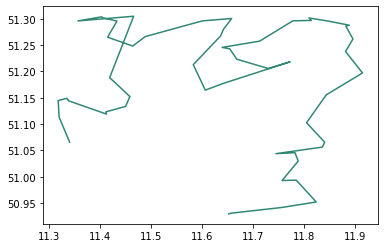

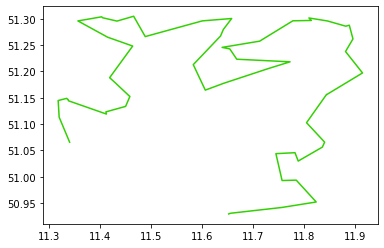

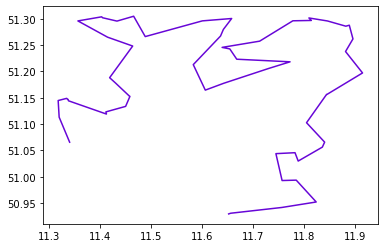

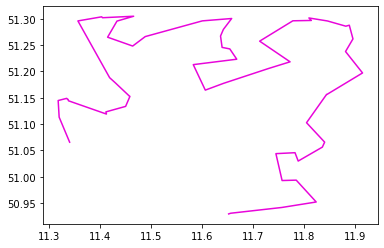

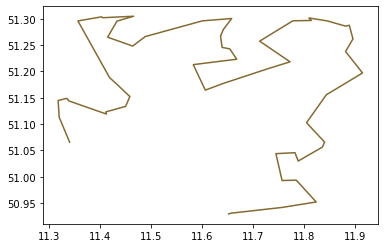

In [158]:
random.seed(42)
plot_list=[orig,list(km_mixed_1),list(km_mixed_2),list(time_mixed_1),list(time_mixed_2)]
for i in range(len(plot_list)):
    #xvalues=[float(coorx[sample_edges[0][0]])]
    #yvalues=[float(coory[sample_edges[0][0]])]
    xvalues=[]
    yvalues=[]
    rand_col=("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    for j in range(len(plot_list[i])):
        #print(i,j)
        xvalues.append(float(coorx[final_edges[int(plot_list[i][j])][0]]))
        yvalues.append(float(coory[final_edges[int(plot_list[i][j])][0]]))
    #xvalues.append(float(coorx[sample_edges[0][0]]))
    #yvalues.append(float(coory[sample_edges[0][0]]))
    plt.plot(xvalues,yvalues,color=rand_col)
    plt.show()


## Combine all the Subtours, to make a huge tour

In [165]:
tourlist[1]
huge_tour=[]
for i in range(len(tourlist)):
    huge_tour+=tourlist[i][0:(len(tourlist[i])-2)]
print(huge_tour)

[172, 293, 156, 73, 220, 193, 94, 101, 283, 423, 410, 291, 292, 402, 364, 399, 195, 19, 446, 78, 397, 266, 263, 138, 8, 34, 167, 205, 56, 264, 314, 379, 451, 385, 11, 366, 422, 353, 23, 435, 478, 440, 96, 262, 39, 28, 87, 279, 13, 265, 377, 194, 313, 318, 182, 55, 309, 326, 204, 118, 125, 229, 315, 149, 289, 252, 462, 480, 103, 413, 257, 486, 280, 124, 238, 181, 255, 224, 296, 113, 297, 454, 177, 330, 243, 258, 328, 335, 316, 420, 76, 273, 228, 390, 400, 339, 134, 368, 407, 7, 305, 86, 107, 381, 5, 447, 404, 212, 259, 388, 375, 474, 38, 174, 384, 48, 41, 18, 24, 200, 191, 396, 208, 183, 187, 349, 492, 140, 417, 236, 367, 322, 82, 416, 129, 464, 127, 196, 445, 178, 117, 17, 256, 254, 246, 62, 216, 395, 418, 44, 133, 358, 370, 3, 419, 360, 472, 1, 186, 433, 199, 488, 52, 148, 437, 306, 371, 336, 165, 102, 483, 111, 45, 457, 482, 66, 484, 240, 2, 126, 81, 162, 448, 282, 146, 226, 476, 438, 383, 128, 352, 169, 192, 300, 83, 232, 189, 233, 490, 201, 70, 100, 409, 60, 487, 139, 54, 288, 27, 

In [168]:
length_of_tour(huge_tour)/100000

2489.2066529100607

In [172]:
##Sadesfully to slow
##Estimate to take one day of computation time
#mixed1(huge_tour,distanc_matrix_13)

KeyboardInterrupt: 

In [62]:
opt_tourlist_1=[]
opt_tourlist_2=[]
for tour in tourlist:
    time_mixed_1=mixed1_time(tour[0:(len(tour)-2)],distanc_matrix_13)
    time_mixed_2=mixed2_time(tour[0:(len(tour)-2)],distanc_matrix_13)
    opt_tourlist_1.append([time_mixed_1[0],length_of_tour(time_mixed_1[0]),time_mixed_1[1]])
    opt_tourlist_2.append([time_mixed_2[0],length_of_tour(time_mixed_2[0]),time_mixed_2[1]])

error 25 26
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 2

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 25.0 26.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26.0 25.0
error 26

error 108 109
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 108.0 109.0
error 108.0 109.0
error 108.0 10

error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 109.0 108.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 108.

error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 108.0 109.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.

error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.

error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.

error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.

error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.

error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.

error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.

error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.

error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.

error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 109.

error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.

error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.

error 108.0 109.0
error 108.0 109.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.0 108.0
error 109.

In [63]:
##timesaving
timesaving_1=[]
timesaving_2=[]
for i in range(len(tourlist)):
    timesaving_1.append(tourlist[i][-1]-opt_tourlist_1[i][-1])
    timesaving_2.append(tourlist[i][-1]-opt_tourlist_2[i][-1])

In [64]:
print(timesaving_1)
print(timesaving_2)
##Manchmal opt 1, manchmal Opt 2 besser
#insgesamt nicht genug Besserung, das man es safe mit einer Tour wenige lösen könnte

[0.3418350050218759, 0.27327913669448556, 0.4168236513826784, 0.2500545787290491, 0.13201475695519527, 0.21802801446049536, 0.40313876913663904, 0.5493622238464884, 0.5277519756123548]
[0.38620956129676287, 0.27327913669448556, 0.4168236513826784, 0.2500545787290491, 0.12118687096305969, 0.21925601481714274, 0.3841054199793632, 0.5638756822132507, 0.5277519756123548]


In [65]:
all_saved_1=0
all_saved_2=0
for i in range(len(timesaving_1)):
    all_saved_1+=timesaving_1[i]
    all_saved_2+=timesaving_2[i]
print(all_saved_1,all_saved_2)

3.112288111839262 3.142542891688147


In [66]:
##How many time values are computed?
counter=0
for i in range(501):
    for j in range(501):
        if (time_matrix[i][j]!=0):
            counter+=1
print(counter)

31822


## Is it possible split the last tour to other?

In [73]:
time_of_tour(opt_tourlist_1[8][0])

error 108.0 109.0


4.797944474570322

In [92]:
rest_time_with_opt=0
for i in range(8):
    rest_time_with_opt+=(9-time_of_tour(opt_tourlist_1[i][0]))

error 26.0 25.0


In [93]:
print(rest_time_with_opt)
#probably not enought time left to add all tours to the tour:

3.257972873309935


In [96]:
rest_time_with_opt_2=0
for i in range(8):
    rest_time_with_opt_2+=(9-(opt_tourlist_2[i][-1]))

In [97]:
print(rest_time_with_opt_2) ##slightly better

3.2882276531588204


In [99]:
opt_tourlist_1[0]

[array([293., 172., 156.,  73., 220., 193.,  94., 101., 283., 423., 410.,
        291., 292., 364., 402., 195., 399.,  19., 446.,  78., 397., 266.,
        263., 138.,   8., 379.,  34., 314., 167., 205., 264.,  56., 451.,
         11., 385., 366., 422., 353.,  23., 435., 478., 440.,  96., 262.,
         39.,  28.,  87., 279.,  13., 265., 377., 194., 313., 318., 182.,
        258., 252., 335.,  76., 420., 316., 454., 296., 297., 113., 413.,
        103., 177., 486., 257., 224., 255., 181., 238., 124., 280., 330.,
        243., 480., 462., 289., 328., 149., 315., 229., 125., 118., 204.,
        326., 309.,  55.]),
 22297735.221703097,
 8.635948735068819]

In [85]:
rest_time=0
for i in range(8):
    rest_time+=(9-(tourlist[i][-1]))

In [86]:
print(rest_time)

0.6734367370830281


In [89]:
type(opt_tourlist_1[0])


list

In [98]:
opt_tourlist_2[8]

[array([211., 121., 415., 109., 108., 369., 206., 160., 301., 145., 479.,
        123., 122., 119., 157., 253., 337., 155., 302., 223., 234.,  99.]),
 20355862.736183926,
 4.797944474570322]

In [105]:
time_matrix[55][211]=nx.astar_path_length(G_all_roads,final_edges[55][0],final_edges[211][0],heuristic=tdist_60,weight='time')/(3600*1000)
print(time_matrix[55][211])

1.2046518738622918


In [113]:
##check if there are valid nodes in the last tour to add to the first tour:
#type(opt_tourlist_2[8][0][0])#we have to translate theme to ints
for j in range(8):
    print("check tour ",j)
    last_station_tour_1=int(opt_tourlist_2[j][0][-1])
    curr_time=opt_tourlist_2[j][-1]
    for i in range(len(opt_tourlist_2[8][0])):
        curr_station=int(opt_tourlist_2[8][0][i])
        now_time=curr_time
        now_time-=time_matrix[last_station_tour_1][0]
        if(time_matrix[last_station_tour_1][curr_station]==0):
            time_matrix[last_station_tour_1][curr_station]=nx.astar_path_length(G_all_roads,final_edges[last_station_tour_1][0],final_edges[curr_station][0],heuristic=tdist_60,weight='time')/(3600*1000)
        add_time=time_matrix[last_station_tour_1][curr_station]
        add_time+=(2/60)
        now_time+=add_time
        if(time_matrix[curr_station][0]==0):
            time_matrix[curr_station][0]=nx.astar_path_length(G_all_roads,final_edges[curr_station][0],final_edges[0][0],heuristic=tdist_60,weight='time')/(3600*1000)
        now_time+=time_matrix[curr_station][0]
        if(now_time<9):
            print(j,curr_station)

check tour  0
check tour  1
check tour  2
check tour  3
check tour  4
check tour  5
check tour  6
check tour  7
7 211
7 121
7 160
7 301
7 122
7 119
7 157
7 253
7 337
7 155
7 302
7 223
7 234
7 99


In [115]:
opt_tourlist_2[7][-1]
##Allein die Servicezeit von 22 Stationen (44min), würde dazu führen, das man nicht alle hinzufügen könne.

8.325097906805109

In [114]:
##to tour 7 we can add at least some more tours
## chose these also with greedy approach
j=7
last_station_tour_1=int(opt_tourlist_2[j][0][-1])
curr_time=opt_tourlist_2[j][-1]
for i in range(len(opt_tourlist_2[8][0])):
        curr_station=int(opt_tourlist_2[8][0][i])
        now_time=curr_time
        now_time-=time_matrix[last_station_tour_1][0]
        if(time_matrix[last_station_tour_1][curr_station]==0):
            time_matrix[last_station_tour_1][curr_station]=nx.astar_path_length(G_all_roads,final_edges[last_station_tour_1][0],final_edges[curr_station][0],heuristic=tdist_60,weight='time')/(3600*1000)
        add_time=time_matrix[last_station_tour_1][curr_station]
        add_time+=(2/60)
        now_time+=add_time
        if(time_matrix[curr_station][0]==0):
            time_matrix[curr_station][0]=nx.astar_path_length(G_all_roads,final_edges[curr_station][0],final_edges[0][0],heuristic=tdist_60,weight='time')/(3600*1000)
        now_time+=time_matrix[curr_station][0]
        if(now_time<9):
            print(j,curr_station)
            print(now_time)

7 211
8.877261625017937
7 121
8.864654768562009
7 160
8.922038443780945
7 301
8.94079153867793
7 122
8.679019978202128
7 119
8.700290118500359
7 157
8.641897976039326
7 253
8.689357558098603
7 337
8.750341688814085
7 155
8.628419557812832
7 302
8.634935039228179
7 223
8.564066620048951
7 234
8.550588853944166
7 99
8.470914319756245


In [116]:
abc=opt_tourlist_2[7][0]

In [118]:
abc.append(42.253)##Have to convert it to a list, to work like that

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [126]:
##find in the greedy way all new stations rechable with tour 7
tour_7=list(opt_tourlist_2[7][0])
tour_8=list(opt_tourlist_2[8][0])
tour_7_time=opt_tourlist_2[7][-1]
still_search=True
counter=0
add_list=[]
while(still_search):
    still_search=False#such nach dieser Suche weiter nach subtour, wenn stations gefunden wurde, kann weiter gesucht
    #werden und die Variable entsprechend auf true gesetzt
    j=7
    last_station_tour_1=int(tour_7[-1])
    curr_time=tour_7_time
    min_new_time=9.1#9.1 würde zu lange sein, hier kommt später die minimal Zeit, die wir durch tourerweiterung bekommen
    add_station=-1## station to add, to tour 7
    remove_from_8=-1
    for i in range(len(tour_8)):
        curr_station=int(tour_8[i])
        now_time=curr_time
        now_time-=time_matrix[last_station_tour_1][0]
        if(time_matrix[last_station_tour_1][curr_station]==0):
            time_matrix[last_station_tour_1][curr_station]=nx.astar_path_length(G_all_roads,final_edges[last_station_tour_1][0],final_edges[curr_station][0],heuristic=tdist_60,weight='time')/(3600*1000)
        add_time=time_matrix[last_station_tour_1][curr_station]
        add_time+=(2/60)
        now_time+=add_time
        if(time_matrix[curr_station][0]==0):
            time_matrix[curr_station][0]=nx.astar_path_length(G_all_roads,final_edges[curr_station][0],final_edges[0][0],heuristic=tdist_60,weight='time')/(3600*1000)
        now_time+=time_matrix[curr_station][0]
        if(now_time<9):
            #print(j,curr_station)
            #print(now_time)
            still_search=True
            if(now_time<min_new_time):#Neues Minima bzgl der Minimas
                min_new_time=now_time
                add_station=curr_station
                remove_from_8=i
    if(still_search):
        tour_8.remove(tour_8[remove_from_8])
        tour_7.append(add_station)
        add_list.append(add_station)
        tour_7_time=min_new_time
        counter+=1

In [127]:
print(counter)
print(add_list)
print(tour_7_time)

4
[99, 234, 223, 302]
8.854646808068125


In [128]:
counter=0
for i in range(501):
    for j in range(501):
        if(time_matrix[i][j]!=0):
            counter+=1
print(counter)

31994


## Plot the optimized tours

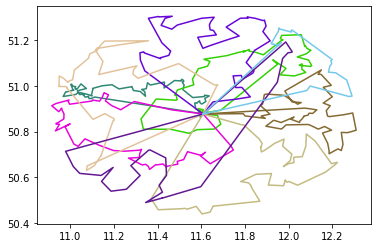

In [132]:
random.seed(42)
for i in range(len(opt_tourlist_2)):
    xvalues=[float(coorx[final_edges[0][0]])]
    yvalues=[float(coory[final_edges[0][0]])]
    rand_col=("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    for j in range(len(opt_tourlist_2[i][0])):
        j=len(opt_tourlist_2[i][0])-j-1
        xvalues.append(float(coorx[final_edges[int(opt_tourlist_2[i][0][j])][0]]))
        yvalues.append(float(coory[final_edges[int(opt_tourlist_2[i][0][j])][0]]))
    xvalues.append(float(coorx[final_edges[0][0]]))
    yvalues.append(float(coory[final_edges[0][0]]))
    plt.plot(xvalues,yvalues,color=rand_col)
plt.show()

In [ ]:
#opt_tourlist_1=[]
#opt_tourlist_2=[]
#for tour in tourlist:
#    time_mixed_1=mixed1_time(tour[0:(len(tour)-2)],distanc_matrix_13)
#    time_mixed_2=mixed2_time(tour[0:(len(tour)-2)],distanc_matrix_13)
#    opt_tourlist_1.append([time_mixed_1[0],length_of_tour(time_mixed_1[0]),time_mixed_1[1]])
#    opt_tourlist_2.append([time_mixed_2[0],length_of_tour(time_mixed_2[0]),time_mixed_2[1]])

In [148]:
time_mixed_2=mixed2_time(opt_tourlist_2[7][0],distanc_matrix_13)
time_mixed_2

(array([276., 244., 209., 363., 235., 295., 405., 341., 275.,  71., 441.,
        429., 163., 114., 173.,  67.,  47., 324., 344., 153.,  72., 499.,
        471., 184., 357., 274., 239.,  50.]),
 8.325097906805109)

In [149]:
time_of_tour(opt_tourlist_2[7][0])

8.325097906805109

In [ ]:
##save the time matrix